# Mathematical Underpinnings - Lab 7

In [90]:
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt

from keras.layers import Input, Dense, Lambda, InputLayer, concatenate
from keras.models import Model, Sequential
from keras import backend as K
from keras import metrics
from keras.datasets import mnist
from keras.utils import to_categorical

from sklearn.model_selection import train_test_split

## Task 1

### a)

In [91]:
def KL_mult_normal(mu1, mu2, Sigma1, Sigma2):
    # the formula is here: https://statproofbook.github.io/P/mvn-kl.html
    return (
        np.dot(mu2 - mu1, np.dot(np.linalg.inv(Sigma2), mu2 - mu1))
        + np.sum(np.diag(np.dot(np.linalg.inv(Sigma2), Sigma1)))
        - np.log(np.linalg.det(Sigma1) / np.linalg.det(Sigma2))
        - mu1.shape[0]
    ) / 2

In [92]:
def T_opt(x, mu1, mu2, Sigma1, Sigma2):
    # compute log(p(x)/q(x)), where p and q are multivariate normal with parameters mu1, Sigma1 and mu2, Sigma2 respectively
    # density of multivariate normal distribution is e.g. here: https://en.wikipedia.org/wiki/Multivariate_normal_distribution
    res = np.zeros(x.shape[0])
    for i in range(x.shape[0]):
        ft = (
            -np.log(np.linalg.det(Sigma1)) / 2
            - np.dot(np.dot(np.linalg.inv(Sigma1), (x[i, :] - mu1)), x[i, :] - mu1) / 2
        )
        st = (
            np.log(np.linalg.det(Sigma2)) / 2
            + np.dot(np.dot(np.linalg.inv(Sigma2), x[i, :] - mu2), x[i, :] - mu2) / 2
        )
        res[i] = ft + st
    return res

### b)

In [93]:
# sample n = 10000 observations out of np.random.multivariate_normal(mu1, Sigma1, size=n)
# and sample n = 10000 observations out of np.random.multivariate_normal(mu2, Sigma2, size=n)
# then concatenate the two matrices (your final x is a matrix 2n x 5)
# then create a vector y that will have n ones and n zeros (of size 2n)

np.random.seed(15)

mu1 = np.array([0.2, 0.2, 0.2, 0, 0])
mu2 = np.array([0, 0, 0.2, 0.2, 0.2])
Sigma1, Sigma2 = (
    np.array(
        [
            [1, p, p, p, p],
            [p, 1, p, p, p],
            [p, p, 1, p, p],
            [p, p, p, 1, p],
            [p, p, p, p, 1],
        ]
    )
    for p in [0.1, -0.2]
)

n = 10000
x1 = np.random.multivariate_normal(mu1, Sigma1, size=n)
x2 = np.random.multivariate_normal(mu2, Sigma2, size=n)
x = np.concatenate([x1, x2])
y = np.array([1] * n + [0] * n)

In [94]:
def DV_fun(y, t):
    # y - an indicator [y[i]=1 if t[i] corresponds to x sampled from the distribution p, y[i]=0 otherwise]
    # t a vector (of the same length as y) t = log(p(x)/q(x))
    n1 = np.sum(y)
    n2 = np.sum(1 - y)
    return np.sum(t * y) / n1 - np.log(np.sum(np.exp(t) * (1 - y)) / n2)

In [95]:
KL_mult_normal(mu1, mu2, Sigma1, Sigma2)

2.169075737042572

In [96]:
DV_fun(y, T_opt(x, mu1, mu2, Sigma1, Sigma2))

2.2554754884728867

### c)

In [97]:
def DV_loss(y_true, T_x):
    n1 = tf.math.reduce_sum(y_true)
    n2 = tf.math.reduce_sum(tf.subtract(tf.convert_to_tensor(1.0), y_true))
    first_term = tf.math.reduce_sum(tf.math.multiply(T_x, y_true)) / n1
    second_term = tf.math.log(
        tf.math.reduce_sum(
            tf.math.multiply(
                tf.math.exp(T_x), tf.subtract(tf.convert_to_tensor(1.0), y_true)
            )
        )
        / n2
    )
    return -(first_term - second_term)

### d)

In [98]:
model_inputs = keras.Input(shape=(5,))
layer_out = Dense(64, activation="softplus")(model_inputs)
# layer_out = Dense(125, activation='tanh')(layer_out)
layer_out = Dense(64)(layer_out)
model_outputs = Dense(1)(layer_out)
model = keras.Model(model_inputs, model_outputs)

optimizer = keras.optimizers.SGD(learning_rate=1e-2)
es = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", mode="min", verbose=1, patience=5
)
model.compile(optimizer=optimizer, loss=DV_loss)

In [99]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)

In [100]:
hist = model.fit(
    x_train,
    y_train,
    epochs=100,
    batch_size=1024,
    validation_data=(x_test, y_test),
    callbacks=[es],
)

Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: -0.0092 - val_loss: -0.0274
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: -0.0319 - val_loss: -0.0428
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: -0.0398 - val_loss: -0.0527
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: -0.0597 - val_loss: -0.0592
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: -0.0626 - val_loss: -0.0638
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: -0.0606 - val_loss: -0.0674
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: -0.0661 - val_loss: -0.0703
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: -0.0736 - val_loss: -0.0728
Epoch 9/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: -0.0721 - val_loss: -0.0750
Epoch 10/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: -0.0755 - val_loss: -0.0771
Epoch 11/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: -0.0786 - val_loss: -0.0792
Epoch 12/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 

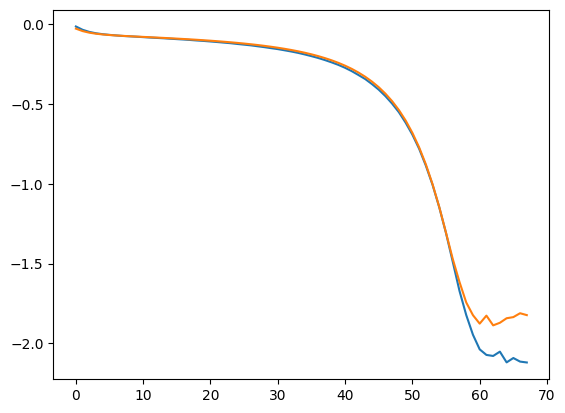

In [101]:
plt.plot(hist.history["loss"])
plt.plot(hist.history["val_loss"])
plt.show()

### e)

In [102]:
t_x_pred = model.predict(x)[:, 0]

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


In [103]:
t_x_opt = T_opt(x, mu1, mu2, Sigma1, Sigma2)

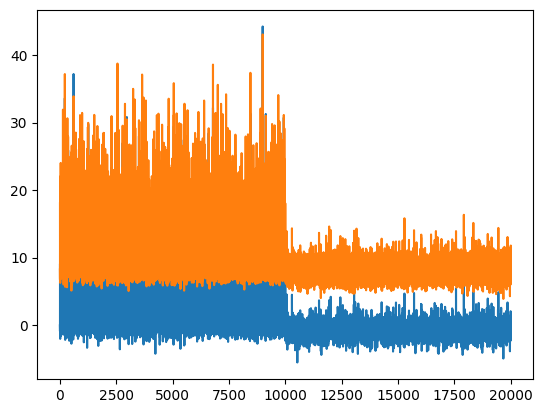

In [104]:
plt.plot(t_x_opt)
plt.plot(t_x_pred)

plt.show()

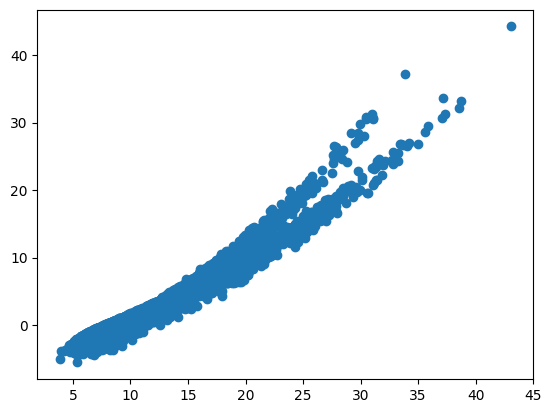

In [105]:
plt.plot(t_x_pred, t_x_opt, "o")
plt.show()

In [106]:
DV_fun(y, t_x_pred)

1.953813529673237

In [107]:
DV_fun(y, t_x_opt)

2.2554754884728867

In [108]:
# new data
np.random.seed(50)
n_new = 10000
x1 = np.random.multivariate_normal(mu1, Sigma1, size=n)
x2 = np.random.multivariate_normal(mu2, Sigma2, size=n)
x_new = np.concatenate([x1, x2])
y_new = np.array([1] * n + [0] * n)

In [109]:
t_x_pred = model.predict(x_new)[:, 0]

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


In [110]:
t_x_opt = T_opt(x_new, mu1, mu2, Sigma1, Sigma2)

In [111]:
DV_fun(y_new, t_x_pred)

1.6567595254346035

In [112]:
DV_fun(y_new, t_x_opt)

2.200498501094945

### f)

In [118]:
def NWJ_loss(y_true, T_x):
    n1 = tf.math.reduce_sum(y_true)
    n2 = tf.math.reduce_sum(tf.subtract(tf.convert_to_tensor(1.0), y_true))
    first_term = tf.math.reduce_sum(tf.math.multiply(T_x, y_true)) / n1
    second_term = (
        tf.math.reduce_sum(
            tf.math.multiply(
                tf.math.exp(tf.subtract(T_x, tf.convert_to_tensor(1.0))),
                tf.subtract(tf.convert_to_tensor(1.0), y_true),
            )
        )
        / n2
    )
    return -(first_term - second_term)

In [149]:
model_inputs = keras.Input(shape=(5,))
layer_out = Dense(8, activation="softplus")(model_inputs)
# layer_out = Dense(125, activation='tanh')(layer_out)
layer_out = Dense(8)(layer_out)
model_outputs = Dense(1)(layer_out)
model = keras.Model(model_inputs, model_outputs)

optimizer = keras.optimizers.SGD(learning_rate=5e-3)
es = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", mode="min", verbose=1, patience=5
)
model.compile(optimizer=optimizer, loss=NWJ_loss)

In [150]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)

In [151]:
hist = model.fit(
    x_train,
    y_train,
    epochs=200,
    batch_size=1024,
    validation_data=(x_test, y_test),
    callbacks=[es],
)

Epoch 1/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.9230 - val_loss: 0.5064
Epoch 2/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4298 - val_loss: 0.2296
Epoch 3/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2075 - val_loss: 0.1225
Epoch 4/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1276 - val_loss: 0.0802
Epoch 5/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0910 - val_loss: 0.0559
Epoch 6/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0574 - val_loss: 0.0381
Epoch 7/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0425 - val_loss: 0.0239
Epoch 8/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0369 - val_loss: 0.0124
Epoch 9/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0229 - val_loss: 0.0029
Epoch 10/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0114 - val_loss: -0.0049
Epoch 11/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0051 - val_loss: -0.0115
Epoch 12/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 

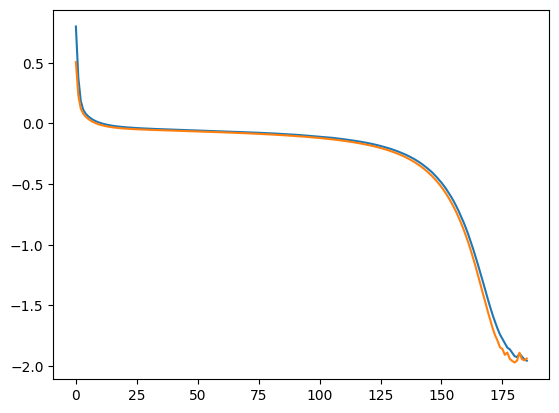

In [152]:
plt.plot(hist.history["loss"])
plt.plot(hist.history["val_loss"])
plt.show()

In [153]:
t_x_pred = model.predict(x)[:, 0]

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 913us/step


In [154]:
t_x_opt = T_opt(x, mu1, mu2, Sigma1, Sigma2)

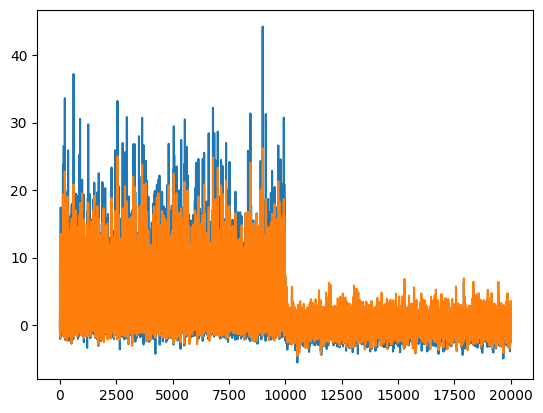

In [155]:
plt.plot(t_x_opt)
plt.plot(t_x_pred)

plt.show()